In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [3]:
### Load Data
boston = load_boston()
print("Keys:", boston.keys())
print("Shape:", boston.data.shape)
print("Columns", boston.feature_names)

Keys: dict_keys(['data', 'target', 'feature_names', 'DESCR'])
Shape: (506, 13)
Columns ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [22]:
# Create a data frame
bos = pd.DataFrame(boston.data, columns=boston.feature_names)
bos['PRICE'] = boston.target
bos.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2

# Data Exploration

In [18]:
# Minimum price of the data
minimum_price = np.min(boston.target)

# Maximum price of the data
maximum_price = np.max(boston.target)

# Mean price of the data
mean_price = np.mean(boston.target)

# Median price of the data
median_price = np.median(boston.target)

# Standard deviation of prices of the data
std_price = np.std(boston.target)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print( "Minimum price: ${:,.2f}".format(minimum_price * 1000))
print( "Maximum price: ${:,.2f}".format(maximum_price * 1000))
print( "Mean price: ${:,.2f}".format(mean_price * 1000))
print( "Median price ${:,.2f}".format(median_price * 1000))

Statistics for Boston housing dataset:

Minimum price: $5,000.00
Maximum price: $50,000.00
Mean price: $22,532.81
Median price $21,200.00


Check the correlation between price and other variables

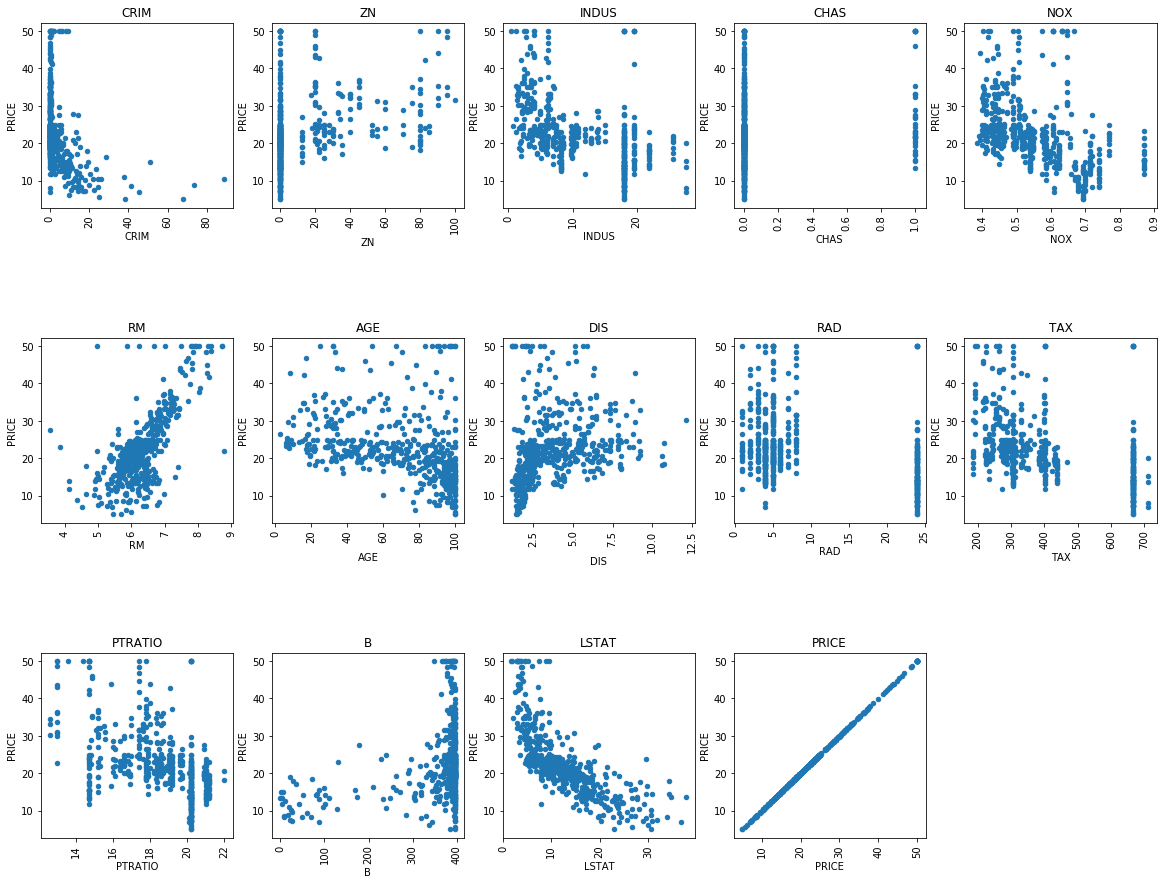

In [23]:
from matplotlib import pyplot as plt
from math import ceil

fig = plt.figure(figsize=(20,15))
cols = 5
rows = ceil(float(bos.shape[1]) / cols)
for i, column in enumerate(bos.columns):
    axs = fig.add_subplot(rows, cols, i + 1)
    axs.set_title(column)
    bos.plot(kind='scatter', x=column, y='PRICE', ax=axs)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

# Build the model

In [7]:
# The column that we want to predict.
y_column = bos['PRICE']

# The columns that we will be making predictions with.
x_columns = bos.drop('PRICE', axis=1)

In [25]:
# split the data into training and test sets and normalize the variables

X_train, X_test, y_train, y_test = train_test_split(x_columns, y_column, test_size = 0.3, random_state = 25)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
y_test = y_scaler.transform(y_test[:, None])[:, 0]

In [71]:
# Instantiate a random forest regression model since we will be predicting on continous variables
# and fit the training set

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", format(metrics.r2_score(y_test, y_pred) * 100, '.2f'), '%')

Accuracy: 84.88 %


Evaluate the model using 10-fold cross-validation. Add Estimate for hyper paramters num_trees and max_features.

In [72]:
num_trees = 100
max_features = 5
kfold = KFold(n_splits=10, random_state=0)
model2 = RandomForestRegressor(n_estimators=num_trees, max_features=max_features)
results = cross_val_score(model2, X_train, y_train, cv=kfold)
print("Accuracy:", format(results.mean() * 100, '.2f'), '%')

Accuracy: 85.22 %


Accuracy score increased by 0.34%

Perform GridSerach to tune the hyper parameters, then use the best estimator for scoring on the test set.

In [74]:
parameters = {"min_samples_split": [2, 5, 10],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 3, 5],
              "max_features": [None, 3, 5],
              "n_estimators": [50, 75, 100]
              }

grid_search = GridSearchCV(RandomForestRegressor(), param_grid=parameters, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(grid_search.best_params_)

print("Accuracy for test data set:\n")
y_pred = grid_search.predict(X_test)

print("Accuracy:", format(metrics.r2_score(y_test, y_pred) * 100, '.2f'), '%')

Best parameters set found on development set:

{'max_depth': None, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for test data set:

Accuracy: 88.20 %


Accuaracy score increased by almost 3% after tuning the hyper parameters

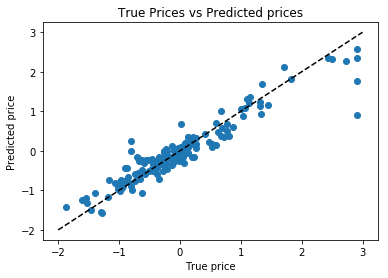

In [75]:
## PLOT true vs predicted prices

plt.scatter(y_test, y_pred)
plt.plot([-2, 3], [-2, 3], '--k')
plt.xlabel("True price")
plt.ylabel("Predicted price")
plt.title("True Prices vs Predicted prices")
plt.show()